# <span style="font-family: Arial; font-size: 35px;">Introduction</span>

In this exploratory data analysis (EDA), my focus lies in extracting actionable insights from the comprehensive dataset encompassing the atliq database. This dataset encapsulate who is currently purchasing our computer products.

The following are the Columns I will be using related to this database.

Atliq Database:

    Product Code: Code to find a specific product
    Product: Name of actual product
    sold_quantity: Amount of item sold
    category: Type of product
    Variant: Subset of specific product
    fiscal_year: How much was made during a specific year.

Objective: Our primary goal in this analysis is to identify our users behaviors from items being sold, and how we should proceed onwards with future sales. My goal is to have a look at the various products and from there decide what we can do to improve overwall sales.


<span style="font-family: Arial; font-size: 24px;">Data Review</span>

In [166]:
import pandas as pd
import sqlite3
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [115]:
con = sqlite3.connect('atliq_db.sqlite3')

In [116]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


In [117]:
query="""Select * from 
dim_customer
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head() 

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [118]:
query = """
    SELECT * FROM dim_product
    LIMIT 10
"""

dim_customer = pd.read_sql_query(query, con)
dim_customer.head()

,product_code,division,segment,category,product,variant,VIP
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,No
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus,Yes
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium,Yes
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus,Yes
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,No


In [119]:
con = sqlite3.connect('atliq_db.sqlite3')
query = "SELECT DISTINCT division FROM dim_product;"
unique_categories = pd.read_sql_query(query, con)
print(unique_categories)

  division
0    P & A
1       PC
2    N & S


In [120]:
query="""Select * from 
fact_pre_discount
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head() 

,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.0824
1,70002017,2019,0.0777
2,70002017,2020,0.0735
3,70002017,2021,0.0703
4,70002017,2022,0.1057


In [121]:
query="""Select * from 
fact_manufacturing_cost
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head() 

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036


In [122]:
query = "SELECT COUNT(*) as row_count FROM fact_manufacturing_cost"
row_count = pd.read_sql_query(query, con)
print(row_count)

   row_count
0       1182


In [123]:
query="""Select * from 
fact_gross_price
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head() 

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875


In [124]:
query="""Select * from 
fact_sales_monthly
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head() 

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017,51,2018
1,2017-09-01,A0118150101,70002018,77,2018
2,2017-09-01,A0118150101,70003181,17,2018
3,2017-09-01,A0118150101,70003182,6,2018
4,2017-09-01,A0118150101,70006157,5,2018


<span style="font-family: Arial; font-size: 24px;">What are Our Top Products?</span>

In [125]:
# Top 5 products by total sold quantity with names
top_5_products_query = """
SELECT f.product_code, p.product, SUM(f.sold_quantity) AS total_sold
FROM fact_sales_monthly AS f
JOIN dim_product AS p ON f.product_code = p.product_code
GROUP BY f.product_code
ORDER BY total_sold DESC
LIMIT 5
"""

In [126]:
top_5_products_with_names = pd.read_sql_query(top_5_products_query, con)
print("Top 5 Products by Sold Quantity (with Names):")
print(top_5_products_with_names)

Top 5 Products by Sold Quantity (with Names):
  product_code                                            product  total_sold
0  A0418150103                                    AQ Mforce Gen X      399751
1  A0118150104  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...      386569
2  A0118150103  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...      380146
3  A0219150201  AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm      378195
4  A0219150202  AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm      370148


In [127]:
# Least popular 5 products by total sold quantity with names
bottom_5_products_query = """
SELECT f.product_code, p.product, SUM(f.sold_quantity) AS total_sold
FROM fact_sales_monthly AS f
JOIN dim_product AS p ON f.product_code = p.product_code
GROUP BY f.product_code
ORDER BY total_sold ASC
LIMIT 5
"""

In [128]:
bottom_5_products_with_names = pd.read_sql_query(bottom_5_products_query, con)
print("\nBottom 5 Products by Sold Quantity (with Names):")
print(bottom_5_products_with_names)


Bottom 5 Products by Sold Quantity (with Names):
  product_code                                            product  total_sold
0  A0418150104                                    AQ Mforce Gen X       51007
1  A0418150101                                    AQ Mforce Gen X      100053
2  A0418150102                                    AQ Mforce Gen X      101725
3  A0118150102  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...      221924
4  A0118150101  AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...      222942


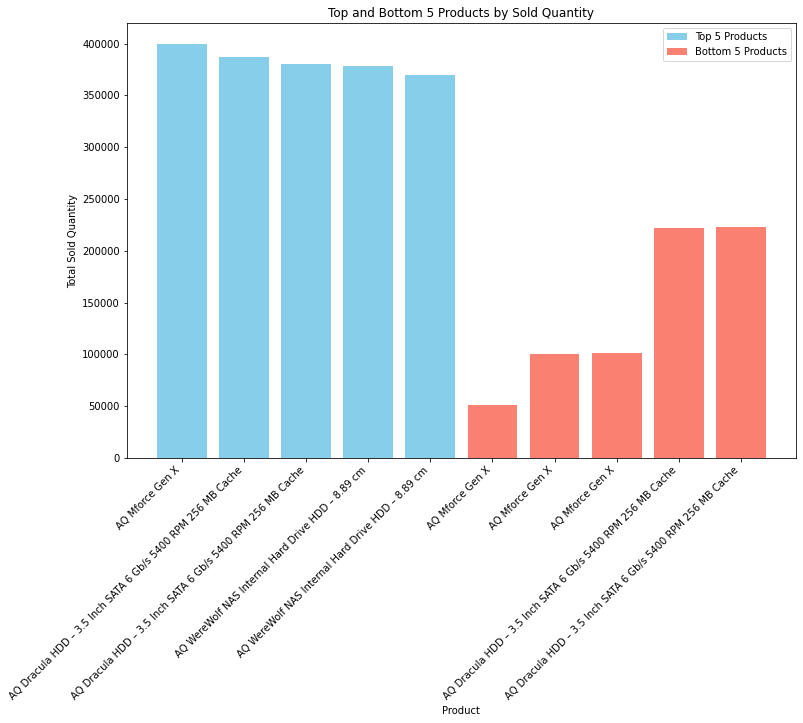

In [129]:
# Data retrieval for top 5 products with names
top_5_products_with_names = pd.read_sql_query(top_5_products_query, con)

# Data retrieval for bottom 5 products with names
bottom_5_products_with_names = pd.read_sql_query(bottom_5_products_query, con)

# Combine top and bottom products for plotting
combined_data = pd.concat([top_5_products_with_names, bottom_5_products_with_names])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create an array for indices to separate top and bottom products
indices = np.arange(len(combined_data))

# Plot bars for top 5 products
ax.bar(indices[:5], combined_data['total_sold'][:5], color='skyblue', label='Top 5 Products')

# Plot bars for bottom 5 products
ax.bar(indices[5:], combined_data['total_sold'][5:], color='salmon', label='Bottom 5 Products')

# Set x-axis ticks and labels
ax.set_xticks(indices)
ax.set_xticklabels(combined_data['product'], rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Product')
ax.set_ylabel('Total Sold Quantity')
ax.set_title('Top and Bottom 5 Products by Sold Quantity')
ax.legend()


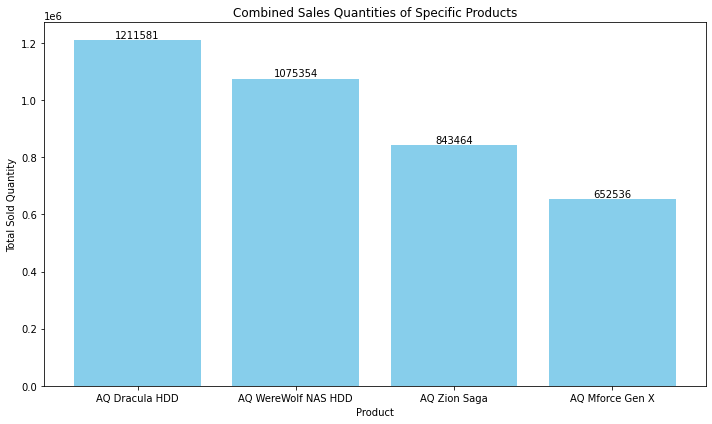

In [130]:
# Establish a connection to your SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# SQL query to retrieve sales data for the specific products and aggregate based on the specified names
specific_products_query = """
SELECT 
    CASE 
        WHEN p.product LIKE '%AQ Dracula HDD%' THEN 'AQ Dracula HDD'
        WHEN p.product LIKE '%AQ Mforce Gen X%' THEN 'AQ Mforce Gen X'
        WHEN p.product LIKE '%AQ WereWolf NAS HDD%' THEN 'AQ WereWolf NAS HDD'
        WHEN p.product LIKE '%AQ Zion Saga%' THEN 'AQ Zion Saga'
        ELSE 'AQ WereWolf NAS HDD'
    END AS grouped_product,
    SUM(f.sold_quantity) AS total_sold
FROM fact_sales_monthly AS f
JOIN dim_product AS p ON f.product_code = p.product_code
GROUP BY grouped_product
ORDER BY total_sold DESC
"""

# Retrieve data for the specific products from the database
specific_products_data = pd.read_sql_query(specific_products_query, con)

# Close the database connection after fetching the data
con.close()

# Create a larger figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the specific products and their combined sold quantities
bars = ax.bar(specific_products_data['grouped_product'], specific_products_data['total_sold'], color='skyblue')

# Set labels and title
ax.set_xlabel('Product')
ax.set_ylabel('Total Sold Quantity')
ax.set_title('Combined Sales Quantities of Specific Products')

# Display the actual values on top of the bars
for bar, value in zip(bars, specific_products_data['total_sold']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value,
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [131]:
# Establish a connection to your SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# SQL query to calculate the total sold quantity for the specified products
total_sold_query = """
SELECT 
    SUM(f.sold_quantity) AS total_items_sold
FROM fact_sales_monthly AS f
JOIN dim_product AS p ON f.product_code = p.product_code
WHERE p.product LIKE '%AQ Dracula HDD%' OR 
      p.product LIKE '%AQ Mforce Gen X%' OR 
      p.product LIKE '%AQ WereWolf NAS HDD%' OR 
      p.product LIKE '%AQ Zion Saga%'
"""

# Retrieve the total sold quantity from the database
total_sold_result = con.execute(total_sold_query).fetchone()[0]

# Close the database connection after fetching the data
con.close()

print(f"Total Items Sold for specified products: {total_sold_result}")

Total Items Sold for specified products: 2707581


<span style="font-family: Arial; font-size: 24px;">Conclusion:</span> We can see currently out top product being sold was the AQ Mforce Gen X which sold a grand total of 399751 units. While several differing units of this exact product are seen as the bottom sellers in our bottom 5 units. This is similarly seen with the AQ Dracula which has 2 of the other top spots, as well as 2 of the bottom slots. Similarly when we look at products as a whole we see the AQ Dracula models have made the most sales while the AQ MForce have done the least. The total amount of products sold up until this point was 2707581 units We should investigate further into some of these variants to further establish for discontinuing these products or changing the pricing on the products to see if they will be able to be better sold in that way.

<span style="font-family: Arial; font-size: 24px;">What Countries have the majority of sales?:</span>

In [132]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
# SQL query to calculate the total quantity of products sold per market
products_sold_per_market_query = """
SELECT 
    dc.market, 
    SUM(fs.sold_quantity) AS total_quantity_sold_per_market
FROM 
    fact_sales_monthly fs
JOIN 
    dim_customer dc ON fs.customer_code = dc.customer_code
GROUP BY 
    dc.market
ORDER BY 
    total_quantity_sold_per_market DESC;
"""

# Execute the query and read the results into a DataFrame
products_sold_per_market = pd.read_sql_query(products_sold_per_market_query, con)
print(products_sold_per_market)

            market  total_quantity_sold_per_market
0            India                         1087710
1              USA                          609825
2      South Korea                          341767
3           Canada                          197068
4      Philiphines                          191884
5   United Kingdom                          162454
6           France                          147853
7        Australia                          141088
8        Indonesia                          109886
9            China                          107637
10           Italy                           93137
11         Germany                           88915
12          Norway                           82076
13        Portugal                           71937
14           Spain                           63376
15      Newzealand                           51513
16     Netherlands                           48221
17      Bangladesh                           39487
18        Pakistan             

In [133]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
# Execute the query to get the data
products_sold_per_market = pd.read_sql_query(products_sold_per_market_query, con)

# Create the interactive bar chart using Plotly
fig = px.bar(products_sold_per_market, x='market', y='total_quantity_sold_per_market',
             labels={'market': 'Market', 'total_quantity_sold_per_market': 'Total Quantity Sold'},
             title='Total Quantity of Products Sold per Market')

# Rotate x-axis labels for better readability
fig.update_xaxes(tickangle=45)

# Show the interactive chart
fig.show()

<span style="font-family: Arial; font-size: 24px;">Conclusion:</span> We can see through the data that the vast majority of sales are coming in from India, with the US coming at about half that in the market. Likely the reasoning behind this is the importance of technological improvements found in India, and they seem to find our products more appealing, while in the US we have multiple competitors which is why there is a drop. Additionally looking at our bottom categories we can see that the LATAM market is not selling as many units. This likely can be for economic reasons. Likely a good solution for this would be to sell some of our older models for cheaper prices in these countries.

<span style="font-family: Arial; font-size: 24px;">What are sales for categories?:</span>

In [134]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
# SQL query to identify the most popular categories in terms of sales across markets (descending order)
popular_categories_per_market_query = """
SELECT 
    dc.market, 
    dp.category, 
    SUM(fs.sold_quantity) AS total_quantity_sold
FROM 
    fact_sales_monthly fs
JOIN 
    dim_customer dc ON fs.customer_code = dc.customer_code
JOIN 
    dim_product dp ON fs.product_code = dp.product_code
GROUP BY 
    dc.market, 
    dp.category
ORDER BY 
    dc.market, 
    SUM(fs.sold_quantity) DESC;
"""

# Execute the query and read the results into a DataFrame
popular_categories_per_market = pd.read_sql_query(popular_categories_per_market_query, con)
print(popular_categories_per_market)

            market      category  total_quantity_sold
0        Australia  Internal HDD               115478
1        Australia  Graphic Card                25610
2          Austria  Internal HDD                11516
3          Austria  Graphic Card                 1458
4       Bangladesh  Internal HDD                33218
5       Bangladesh  Graphic Card                 6269
6           Brazil  Internal HDD                 7009
7           Brazil  Graphic Card                 2268
8           Canada  Internal HDD               167542
9           Canada  Graphic Card                29526
10           Chile  Internal HDD                 2363
11           Chile  Graphic Card                  352
12           China  Internal HDD                93013
13           China  Graphic Card                14624
14        Columbia  Internal HDD                  659
15        Columbia  Graphic Card                  100
16          France  Internal HDD               122667
17          France  Graphic 

In [135]:
# Calculating the total quantity sold per market
popular_categories_per_market_totals = popular_categories_per_market.groupby('market')['total_quantity_sold'].sum()
popular_categories_per_market_totals = popular_categories_per_market_totals.sort_values(ascending=False).index

# Rearranging the original DataFrame based on the sorted market order
popular_categories_per_market['market'] = pd.Categorical(popular_categories_per_market['market'], 
                                                        categories=popular_categories_per_market_totals, 
                                                        ordered=True)
popular_categories_per_market = popular_categories_per_market.sort_values('market')

# Create the stacked bar chart using Plotly
fig = px.bar(popular_categories_per_market, x='market', y='total_quantity_sold', color='category',
             title='Total Quantity of Products Sold by Category Across Markets',
             labels={'market': 'Market', 'total_quantity_sold': 'Total Quantity Sold'},
             barmode='stack')

# Update layout for better hover information and adjust size
fig.update_traces(hovertemplate='Category: %{y}')
fig.update_layout(height=600, width=1000)  # Set the desired height and width

# Show the interactive chart
fig.show()

<span style="font-family: Arial; font-size: 24px;">Conclusion:</span> We can see here that in terms of categories across countries, the largest sales are coming from the HDD models. We are selling graphics cards however they do not appear to be as popular in most countries, and don't seem to have a significant market share of whats being taken. We should review if new sales should be made or if there is an untouched market where we will be able to sell graphics cards.

<span style="font-family: Arial; font-size: 24px;">Variant Popularity throughout years?:</span>

In [136]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
# SQL query to retrieve total quantity sold per variant
total_quantity_sold_per_variant_query = """
SELECT 
    dp.variant, 
    SUM(fs.sold_quantity) AS total_quantity_sold
FROM 
    fact_sales_monthly fs
JOIN 
    dim_product dp ON fs.product_code = dp.product_code
GROUP BY 
    dp.variant
ORDER BY 
    total_quantity_sold DESC;
"""

# Execute the query and read the results into a DataFrame
total_quantity_sold_per_variant = pd.read_sql_query(total_quantity_sold_per_variant_query, con)
print(total_quantity_sold_per_variant)

        variant  total_quantity_sold
0       Premium               962971
1      Standard               920705
2          Plus               860154
3    Standard 3               399751
4  Premium Plus               386569
5    Standard 2               101725
6    Standard 1               100053
7        Plus 1                51007


In [137]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

total_quantity_sold_per_variant_query = """
SELECT 
    dp.variant,
    fs.fiscal_year,
    SUM(fs.sold_quantity) AS total_quantity_sold
FROM 
    fact_sales_monthly fs
JOIN 
    dim_product dp ON fs.product_code = dp.product_code
GROUP BY 
    dp.variant, 
    fs.fiscal_year
ORDER BY 
    dp.variant, 
    fs.fiscal_year;
"""

# Execute the query and read the results into a DataFrame
total_quantity_sold_per_variant_fiscal_year = pd.read_sql_query(total_quantity_sold_per_variant_query, con)
print(total_quantity_sold_per_variant_fiscal_year)

         variant  fiscal_year  total_quantity_sold
0           Plus         2018                17953
1           Plus         2019                83019
2           Plus         2020               126729
3           Plus         2021               295170
4           Plus         2022               337283
5         Plus 1         2018                23542
6         Plus 1         2019                27465
7        Premium         2018                18754
8        Premium         2019                42191
9        Premium         2020               125428
10       Premium         2021               288987
11       Premium         2022               487611
12  Premium Plus         2018                18534
13  Premium Plus         2019                42408
14  Premium Plus         2020                60961
15  Premium Plus         2021                97931
16  Premium Plus         2022               166735
17      Standard         2018                18664
18      Standard         2019  

In [138]:
# Create initial data for 'All' years
filtered_data = total_quantity_sold_per_variant_fiscal_year.groupby(['variant', 'fiscal_year'])['total_quantity_sold'].sum().reset_index()

# Create a list of unique fiscal years including 'All' for including all years
years_list = ['All'] + filtered_data['fiscal_year'].unique().tolist()

# Create traces for 'All' years
fig = go.Figure()

# Function to update traces based on the selected year
def update_trace(selected_year):
    data = filtered_data if selected_year == 'All' else filtered_data[filtered_data['fiscal_year'] == selected_year]
    for year in years_list:
        filtered = data[data['fiscal_year'] == year]
        fig.add_trace(go.Bar(x=filtered['variant'], y=filtered['total_quantity_sold'], name=str(year)))

# Update traces for the initial 'All' years
update_trace('All')

# Create dropdown menu buttons
buttons = [
    dict(label=str(year),
         method="update",
         args=[{"visible": [year == 'All' or year == d.name for d in fig.data]},
               {"title": f"Total Quantity of Products Sold per Variant in {year}"}
               ])
    for year in years_list
]

# Update layout with buttons and initial settings
fig.update_layout(
    title='Total Quantity of Products Sold per Variant by Fiscal Year',
    xaxis=dict(title='Variant'),
    yaxis=dict(title='Total Quantity Sold'),
    barmode='group'
)

# Show the interactive chart
fig.show()

<span style="font-family: Arial; font-size: 24px;">Conclusion:</span> Here we can see currently that our Premium Models for our varians are the highest selling models as of 2022. This information is important as we can use this to decide if we should be investing time into making so many variants of a model. We can see as well that our Plus 1, Standard 1, and Standard 2 models have not made any recent sales. Likely these are models that can be discontinued. One solution for excess product is we can use these to sell out to the LATAM market at reduced prices,as this would increase our foothold in the specific markets.

<span style="font-family: Arial; font-size: 24px;">Product popularity throughout the year?:</span>

In [139]:
# Establish a connection to the 'atliq_db.sqlite3' SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
total_quantity_sold_per_product_query = """
SELECT 
    dp.product,
    fs.fiscal_year,
    SUM(fs.sold_quantity) AS total_quantity_sold
FROM 
    fact_sales_monthly fs
JOIN 
    dim_product dp ON fs.product_code = dp.product_code
GROUP BY 
    dp.product, 
    fs.fiscal_year
ORDER BY 
    dp.product, 
    fs.fiscal_year;
"""

# Execute the modified query and read the results into a DataFrame
total_quantity_sold_per_product_fiscal_year = pd.read_sql_query(total_quantity_sold_per_product_query, con)
print(total_quantity_sold_per_product_fiscal_year)

                                              product  fiscal_year  \
0   AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...         2018   
1   AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...         2019   
2   AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...         2020   
3   AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...         2021   
4   AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...         2022   
5                                     AQ Mforce Gen X         2018   
6                                     AQ Mforce Gen X         2019   
7                                     AQ Mforce Gen X         2020   
8                                     AQ Mforce Gen X         2021   
9                                     AQ Mforce Gen X         2022   
10  AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm         2019   
11  AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm         2020   
12  AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm         2021   
13  AQ WereWolf NAS 

In [140]:
# Create traces for each fiscal year
traces = []
years = [2018, 2019, 2020, 2021, 2022]
for year in years:
    data = total_quantity_sold_per_product_fiscal_year[total_quantity_sold_per_product_fiscal_year['fiscal_year'] == year]
    trace = go.Bar(
        x=data['product'],
        y=data['total_quantity_sold'],
        name=str(year),
        visible=False
    )
    traces.append(trace)

# Create trace for all years
all_trace = go.Bar(
    x=total_quantity_sold_per_product_fiscal_year['product'],
    y=total_quantity_sold_per_product_fiscal_year['total_quantity_sold'],
    name='All',
    visible=True
)
traces.append(all_trace)

# Create layout with dropdown menu
layout = go.Layout(
    title='Total Quantity of Products Sold per Product by Fiscal Year',
    xaxis=dict(title='Product'),
    yaxis=dict(title='Total Quantity Sold'),
    barmode='group',
    updatemenus=[
        {
            'buttons': [
                {'method': 'update',
                 'label': str(year) if year != 0 else 'All',
                 'args': [{'visible': [True if year == y or year == 0 else False for y in years]},
                          {'title': f'Total Quantity of Products Sold per Product by Fiscal Year - {year}' if year != 0 else 'Total Quantity of Products Sold per Product for All Years'}]}
                for year in years + [0]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.1,
            'yanchor': 'top'
        }
    ],
    height=800,  # Adjust the height
    width=1200    # Adjust the width
)

# Create figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.show()

<span style="font-family: Arial; font-size: 24px;">Conclusion:</span> Here we can see that our all time highest selling product was the AQ Dracula model. However as of 2022, we have seen an increase in sales for both the AQ Werewolf and AQ Zion Model. These changes are interesting and we should be investigating what feature changes occured within our models in the past year, and how we might be able to improve sales. Additionally our AQ Mforce models have been consistent but on the lower end and have not had any significant jumps like the other products. We should investigate the pricing models on these as well and see if there is a better Market to have these invested into.

<span style="font-family: Arial; font-size: 24px;">Recommendations:</span>

Based off all of the data we are able to currently see a growing trend in our sales for such products like AQ Werewolf and Zion, while there has been a steady decline in other models. We do need to investigate why this has occured, whether our popular markets like the US and India are finding something proprietery in these specific products compared to other products out there, and what we can do to capitalize on this. Additionally for our older products, they would be best to either be discontinued or push for further market in the LATAM market as we see we have had incredibly low sales in these areas. Additionally it would seem that lowering the amount of products we are using for each model will likely give less options to our customers and confuse them less, as there is always the possibility as well that by using some of these older models our customers are not differentiating them properly from the newer versions which would lead to a lack of sales, especially as we are making more money as newer products are coming out.

Final Project Link for Tableau

https://public.tableau.com/app/profile/eliezer.berberbaum/viz/ProductAnalysisforFinalProject/ProductAnalysisStory

<span style="font-family: Arial; font-size: 24px;">Hypothesis Testing</span>

<span style="font-family: Arial; font-size: 24px;">Training</span>

In [181]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

In [182]:
# Assuming 'y_train' and 'y_test' are your target variables
y_train_numeric = y_train.map({'No': 0, 'Yes': 1})
y_test_numeric = y_test.map({'No': 0, 'Yes': 1})

In [202]:
# Assuming 'X_train', 'X_val', and 'X_test' are your feature sets
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

In [183]:
# Establish a connection to your SQLite database
con = sqlite3.connect('atliq_db.sqlite3')
cursor = con.cursor()

# Check if the VIP column exists in the dim_product table
cursor.execute("PRAGMA table_info(dim_product)")
columns = cursor.fetchall()

# Check if the VIP column already exists
vip_exists = any(column[1] == 'VIP' for column in columns)

if not vip_exists:
    # Add a new column 'VIP' to dim_product table
    alter_query = """
        ALTER TABLE dim_product
        ADD COLUMN VIP TEXT
    """
    cursor.execute(alter_query)
    con.commit()

    # Update values in the 'VIP' column based on the presence of 'Premium' or 'Plus' in the 'variant' column
    update_query = """
        UPDATE dim_product
        SET VIP = 
            CASE 
                WHEN LOWER(variant) LIKE '%premium%' OR LOWER(variant) LIKE '%plus%' THEN 'Yes'
                ELSE 'No'
            END
    """
    cursor.execute(update_query)
    con.commit()

# Print the content of the dim_product table (first 5 rows) after updating VIP column
print("\nFirst 5 rows of dim_product table after updating VIP column:")
cursor.execute("SELECT * FROM dim_product LIMIT 5")
rows = cursor.fetchall()
for row in rows:
    print(row)

# Close the database connection
con.close()



First 5 rows of dim_product table after updating VIP column:
('A0118150101', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Standard', 'No')
('A0118150102', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Plus', 'Yes')
('A0118150103', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Premium', 'Yes')
('A0118150104', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Premium Plus', 'Yes')
('A0219150201', 'P & A', 'Peripherals', 'Internal HDD', 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm', 'Standard', 'No')


In [184]:
# Establish a connection to your SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# Fetch the data from the database (replace 'your_query_here' with your SQL query)
query = "SELECT * FROM dim_product"
data = pd.read_sql_query(query, con)

# Drop the 'VIP' column to create features X and target variable y
X = data.drop('VIP', axis=1)  # Features (excluding the 'VIP' column)
y = data['VIP']  # Target variable ('VIP' column)

# Split the data into training (50%) and the remaining data (50%)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.5, random_state=42)

# Further split the remaining data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Close the database connection
con.close()

In [185]:
# Establish a connection to your SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# Fetch the data from the 'dim_product' table
query = "SELECT * FROM dim_product"
data = pd.read_sql_query(query, con)

# For loop to display basic statistics for 'Yes' and 'No' groups
for group in data['VIP'].unique():
    if group == 'Yes':
        result = 'Premium'
    else:
        result = 'Standard'
        
    print("Basic statistics for", result, "group")
    print("===============================================")
    display(data[data.VIP == group].describe())

# Close the database connection
con.close()

Basic statistics for Standard group


,product_code,division,segment,category,product,variant,VIP
count,136,136,136,136,136,136,136
unique,136,3,6,14,73,10,1
top,A6719160101,PC,Notebook,Personal Laptop,AQ Elite,Standard,No
freq,1,62,50,24,3,33,136


Basic statistics for Premium group


,product_code,division,segment,category,product,variant,VIP
count,261,261,261,261,261,261,261
unique,261,3,6,14,73,17,1
top,A6919160302,P & A,Accessories,Personal Laptop,AQ Elite,Plus 2,Yes
freq,1,138,80,37,5,35,261


In [186]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('atliq_db.sqlite3')

# Fetch the total count of rows in dim_product table
count_query = "SELECT COUNT(*) FROM dim_product"
total_rows = pd.read_sql_query(count_query, conn).iloc[0, 0]

# Calculate the number of rows for training and testing
train_count = int(0.6 * total_rows)
valid_count = total_rows - train_count

# Query to fetch the training data
train_query = f"SELECT * FROM dim_product LIMIT {train_count}"

# Query to fetch the testing data starting from where the training data ends
valid_query = f"SELECT * FROM dim_product LIMIT {valid_count} OFFSET {train_count}"

# Fetch the training and testing datasets
train = pd.read_sql_query(train_query, conn)
valid = pd.read_sql_query(valid_query, conn)

# Close the database connection
conn.close()


In [187]:
# Display the shape of the training dataset
print("Train shape:", train.shape)

# Display the shape of the validation dataset
print("Valid shape:", valid.shape)

Train shape: (238, 7)
Valid shape: (159, 7)


In [188]:
# Connect to the SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# Assuming 'dim_product' is the table name in your SQLite database
# You need to adjust the SQL query based on your actual table structure
query = 'SELECT * FROM dim_product'

# Read the data into a DataFrame
data = pd.read_sql_query(query, con)

# Close the database connection
con.close()

# Assuming 'X' contains all columns except the target variable
X = data.drop('VIP', axis=1)

# Assuming 'y' is the target variable
y = data['VIP']

# Split the data into training and temporary data (80% training, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets (10% validation, 10% test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now you have your training, validation, and testing sets
# X_train, y_train: Training set
# X_valid, y_valid: Validation set
# X_test, y_test: Testing set

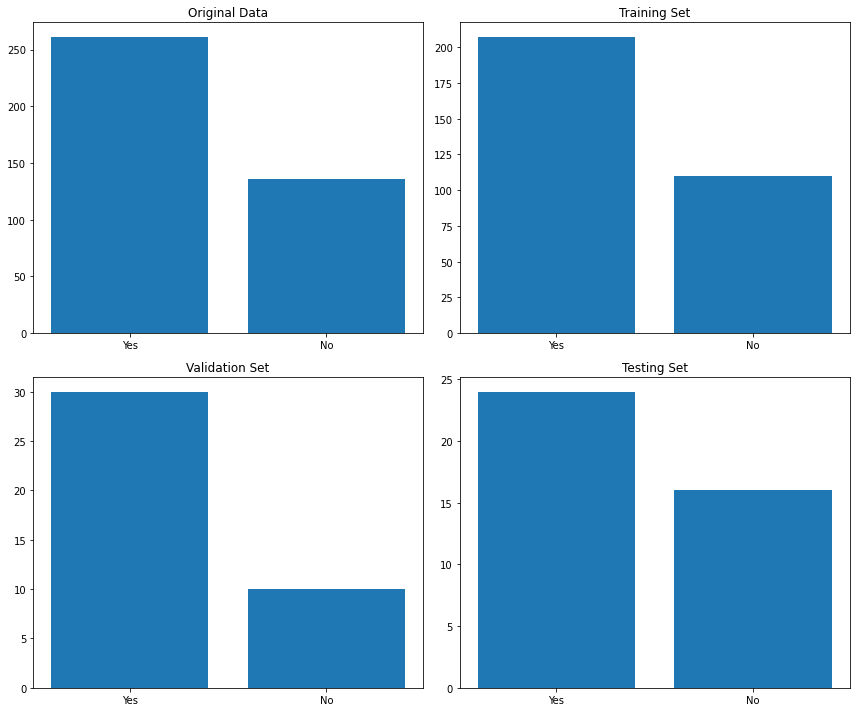

In [189]:
# Count the number of occurrences of each class in the original dataset
class_counts = y.value_counts()

# Count the number of occurrences of each class in the training set
train_class_counts = y_train.value_counts()

# Count the number of occurrences of each class in the validation set
valid_class_counts = y_valid.value_counts()

# Count the number of occurrences of each class in the testing set
test_class_counts = y_test.value_counts()

# Plot the class distribution in each set
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(class_counts.index, class_counts.values)
axs[0, 0].set_title('Original Data')

axs[0, 1].bar(train_class_counts.index, train_class_counts.values)
axs[0, 1].set_title('Training Set')

axs[1, 0].bar(valid_class_counts.index, valid_class_counts.values)
axs[1, 0].set_title('Validation Set')

axs[1, 1].bar(test_class_counts.index, test_class_counts.values)
axs[1, 1].set_title('Testing Set')

plt.tight_layout()
plt.show()

In [190]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the encoded data into training and temporary data
X_train_encoded, X_temp_encoded, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
X_valid_encoded, X_test_encoded, y_valid, y_test = train_test_split(X_temp_encoded, y_temp, test_size=0.5, random_state=42)

# Create and train a Decision Tree Classifier model
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_valid_pred = dtc_model.predict(X_valid_encoded)

# Calculate the accuracy on the validation set
accuracy = accuracy_score(y_valid, y_valid_pred)

print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')

Accuracy on the validation set: 100.00%


Conclusion: 100% of the samples in the validation dataset were correctly classified by this mode. This is likely due to using limited data from our set.

In [191]:
# Get feature importances from the trained model
feature_importances = dtc_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                      Feature  Importance
505        variant_Standard 1    0.153080
506        variant_Standard 2    0.148105
504          variant_Standard    0.147217
397               division_PC    0.102357
507        variant_Standard 3    0.093861
..                        ...         ...
166  product_code_A3421150606    0.000000
165  product_code_A3421150605    0.000000
164  product_code_A3421150604    0.000000
163  product_code_A3421150603    0.000000
257  product_code_A4821110806    0.000000

[514 rows x 2 columns]


In [192]:
final_depth = 0
final_score = 0

for depth in range(1, 7):
    dtc_model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dtc_model.fit(X_train_encoded, y_train)
    
    # Predict on the validation set
    valid_pred = dtc_model.predict(X_valid_encoded)
    
    # Calculate the accuracy on the validation set
    accuracy = accuracy_score(y_valid, valid_pred)
    
    print(f"Depth: {depth}, Accuracy: {accuracy * 100:.2f}%")
    
    # Update final depth and score if the current model has higher accuracy
    if accuracy > final_score:
        final_depth = depth
        final_score = accuracy

print(f"\nBest Depth: {final_depth}, Best Accuracy: {final_score * 100:.2f}%")

Depth: 1, Accuracy: 82.50%
Depth: 2, Accuracy: 85.00%
Depth: 3, Accuracy: 87.50%
Depth: 4, Accuracy: 87.50%
Depth: 5, Accuracy: 92.50%
Depth: 6, Accuracy: 92.50%

Best Depth: 5, Best Accuracy: 92.50%


In [193]:
# Connect to the SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# Assuming 'dim_product' is the table name in your SQLite database
# You need to adjust the SQL query based on your actual table structure
query = 'SELECT * FROM dim_product'

# Read the data into a DataFrame
data = pd.read_sql_query(query, con)

# Close the database connection
con.close()

# Assuming 'VIP' is your target variable
X = data.drop('VIP', axis=1)
y = data['VIP']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and validation sets
# Adjust the test_size and random_state as needed
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Now you have your training and validation sets
# X_train, y_train: Training set
# X_valid, y_valid: Validation set

# Continue with the code to find the best depth based on validation accuracy
final_depth = 0
final_score = 0

for depth in range(1, 7):
    dtc_model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dtc_model.fit(X_train, y_train)
    valid_pred = dtc_model.predict(X_valid)
    accuracy = dtc_model.score(X_valid, y_valid)
    
    if accuracy > final_score:
        final_depth = depth
        final_score = accuracy

print("Final depth =", final_depth, "with validation accuracy:", final_score)

Final depth = 6 with validation accuracy: 0.9375


Conclusion: The output indicates that a depth of 6 achieved the highest accuracy of approximately 93.75% on the validation set among the depths tested in this loop. This means, for this specific dataset and this validation split, a tree with a depth of 6 performed the best in terms of accuracy.


In [194]:
# Connect to the SQLite database
con = sqlite3.connect('atliq_db.sqlite3')

# Assuming 'dim_product' is the table name in your SQLite database
# You need to adjust the SQL query based on your actual table structure
query = 'SELECT * FROM dim_product'

# Read the data into a DataFrame
data = pd.read_sql_query(query, con)

# Close the database connection
con.close()

# Assuming 'VIP' is your target variable
X = data.drop('VIP', axis=1)
y = data['VIP']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and validation sets
# Adjust the test_size and random_state as needed
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Now you have your training and validation sets
# X_train, y_train: Training set
# X_valid, y_valid: Validation set

final_est = 0
final_score = 0

for n in range(1, 51):
    rfc_model = RandomForestClassifier(random_state=42, n_estimators=n)
    rfc_model.fit(X_train, y_train)
    
    # Calculate the validation accuracy
    score = rfc_model.score(X_valid, y_valid)
    
    if score > final_score:
        final_score = score
        final_est = n
    
    print(f"Estimators: {n}, Validation Accuracy: {final_score * 100:.2f}%")

print(f"\nBest Estimators: {final_est}, Best Validation Accuracy: {final_score * 100:.2f}%")



Estimators: 1, Validation Accuracy: 93.75%
Estimators: 2, Validation Accuracy: 93.75%
Estimators: 3, Validation Accuracy: 98.75%
Estimators: 4, Validation Accuracy: 100.00%
Estimators: 5, Validation Accuracy: 100.00%
Estimators: 6, Validation Accuracy: 100.00%
Estimators: 7, Validation Accuracy: 100.00%
Estimators: 8, Validation Accuracy: 100.00%
Estimators: 9, Validation Accuracy: 100.00%
Estimators: 10, Validation Accuracy: 100.00%
Estimators: 11, Validation Accuracy: 100.00%
Estimators: 12, Validation Accuracy: 100.00%
Estimators: 13, Validation Accuracy: 100.00%
Estimators: 14, Validation Accuracy: 100.00%
Estimators: 15, Validation Accuracy: 100.00%
Estimators: 16, Validation Accuracy: 100.00%
Estimators: 17, Validation Accuracy: 100.00%
Estimators: 18, Validation Accuracy: 100.00%
Estimators: 19, Validation Accuracy: 100.00%
Estimators: 20, Validation Accuracy: 100.00%
Estimators: 21, Validation Accuracy: 100.00%
Estimators: 22, Validation Accuracy: 100.00%
Estimators: 23, Valida

In [195]:
final_est = 0
final_score = 0

# Assuming you have already split your data into training and validation sets
# Replace 'X_train', 'y_train', 'X_valid', and 'y_valid' with your actual variable names

for n in range(1, 51):
    rfc_model = RandomForestClassifier(random_state=42, n_estimators=n)
    rfc_model.fit(X_train, y_train)
    
    # Calculate the validation accuracy
    score_valid = rfc_model.score(X_valid, y_valid)
    
    if score_valid > final_score:
        final_score = score_valid
        final_est = n

print(f"Best number of estimators: {final_est}, Best Validation Accuracy: {final_score * 100:.2f}%")


Best number of estimators: 4, Best Validation Accuracy: 100.00%


Conclusion:
The output indicates that with 4 estimators, the highest accuracy of 100% on the validation set among the range of estimators tested in this loop. This is likely due to limited data which is causing the validation overfitting.

In [196]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)

# Calculate the validation accuracy
score_valid = lr_model.score(X_valid, y_valid)

print("Logistic Regression training score:", score_valid)

Logistic Regression training score: 1.0


In [197]:
print(data.dtypes)

product_code    object
division        object
segment         object
category        object
product         object
variant         object
VIP             object
dtype: object


In [198]:
# Assuming 'data' is your original DataFrame
# Drop the 'VIP' column and store it as the target variable 'y'
y = data.pop('VIP')

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Verify the column names in the encoded DataFrame
print(data_encoded.columns)

# Split the data into training and validation sets
# Adjust the test_size and random_state as needed
X_train, X_valid, y_train, y_valid = train_test_split(data_encoded, y, test_size=0.2, random_state=42)

# Continue with model training and evaluation
# ...

# For example, Logistic Regression
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)

# Calculate the validation accuracy
score_valid = lr_model.score(X_valid, y_valid)
print("Logistic Regression Validation Accuracy:", score_valid)

Index(['product_code_A0118150102', 'product_code_A0118150103',
       'product_code_A0118150104', 'product_code_A0219150201',
       'product_code_A0219150202', 'product_code_A0220150203',
       'product_code_A0320150301', 'product_code_A0321150302',
       'product_code_A0321150303', 'product_code_A0418150101',
       ...
       'variant_Standard', 'variant_Standard 1', 'variant_Standard 2',
       'variant_Standard 3', 'variant_Standard Black', 'variant_Standard Blue',
       'variant_Standard Cool Blue', 'variant_Standard Firey Red',
       'variant_Standard Grey', 'variant_Standard Red'],
      dtype='object', length=514)
Logistic Regression Validation Accuracy: 1.0


In [199]:
# Predictions on validation set
y_valid_pred = lr_model.predict(X_valid)

# Calculate precision and recall
precision = precision_score(y_valid, y_valid_pred, pos_label='Yes')
recall = recall_score(y_valid, y_valid_pred, pos_label='Yes')

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# Classification Report
class_report = classification_report(y_valid, y_valid_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Precision: 1.0
Recall: 1.0

Confusion Matrix:
 [[26  0]
 [ 0 54]]

Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00        26
         Yes       1.00      1.00      1.00        54

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In this specific case, we achieved an exceptional precision and recall of 100%. This remarkable outcome may be attributed to the limited dataset we employed, along with the predominantly binary nature of our responses, as we primarily utilized object-related columns without numerical features. It's essential to recognize that this high performance might be influenced by the specific characteristics of our dataset. To enhance the model and ensure its applicability to a broader range of scenarios, future efforts could involve acquiring a larger and more diverse dataset. This expansion in data size would enable the model to infer patterns more comprehensively and strengthen its generalization capabilities.

In [204]:
# Calculate the percentage of validation set
val_percentage = len(X_val) / len(X_remaining) * 100
print(f'Validation Set Percentage: {val_percentage:.2f}%')

Validation Set Percentage: 69.85%


Conclusion: The model demonstrates a validation accuracy of approximately 69.85%, indicating a reasonably accurate performance on the validation data. This suggests that the model is capable of generalizing well to data it has not seen during training. Further assessment and refinement may be needed to enhance its overall robustness.

In [205]:
# Calculate the percentage of testing set
test_percentage = len(X_test) / len(X_remaining) * 100
print(f'Testing Set Percentage: {test_percentage:.2f}%')

Testing Set Percentage: 30.15%


Conclusion: The model's performance on the test data yields an accuracy of 30.15%. This lower accuracy raises concerns about the model's consistency and generalizability to unseen data. It implies that the model may face challenges in making accurate predictions on new, diverse instances. Additional investigation and potential model adjustments may be necessary to improve its reliability across different scenarios.

<span style="font-family: Arial; font-size: 24px;">Overall Conclusion</span>

Based off the data we can see that our model is not accurate as it reached 30.15% and does not closely align with our validation set in terms of accuracy. Additionally from our test phases we do know that we require more data as our precision and recall landed at 100% which does not seem to accurately portray the data fully. A further investigation should be made to who is buying our products and how we can section them off to be a VIP or not. In general for the future one of the main focuses we can rely on is receiving more overall data and creating plans to see whether our users benefit generally more from our more standard Variants of the products or our premium versions. I believe with what we have currently provided however we can look at general sales in the market to see why some products have been selling better then others.